# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- compute distance between 2 ghost spots (distance + flux + size?)
- compute distance between 2 series of ghosts spots


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import find_nearest_ghost, match_ghosts, compute_reduced_distance
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0.02

Direct path is number 28
  central impact point is (0.099465, 0.000025)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 691.1873


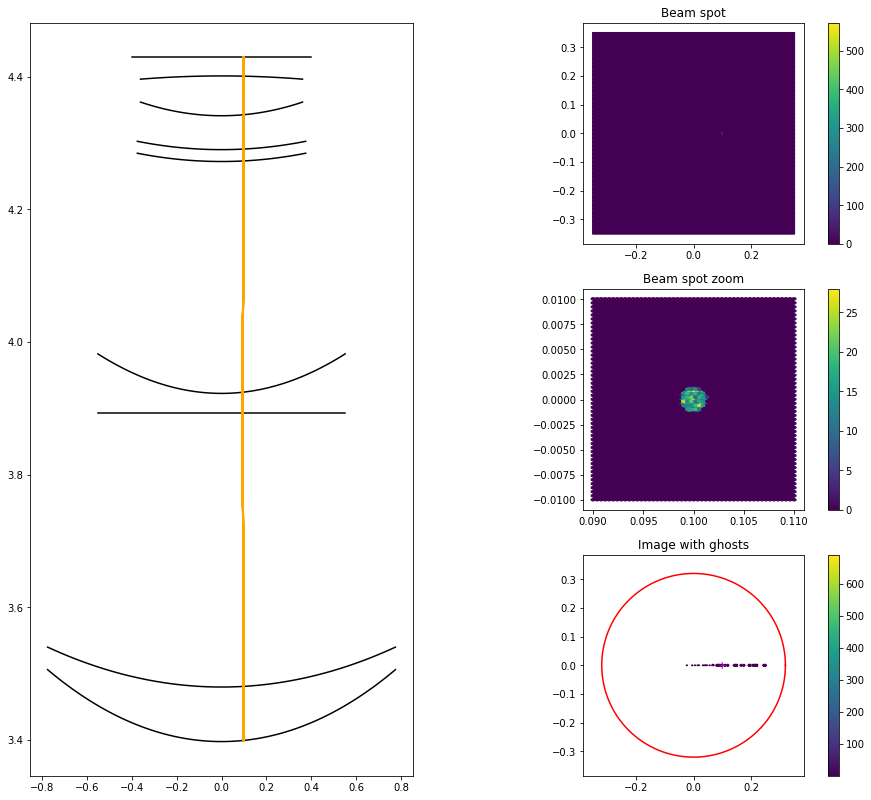

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


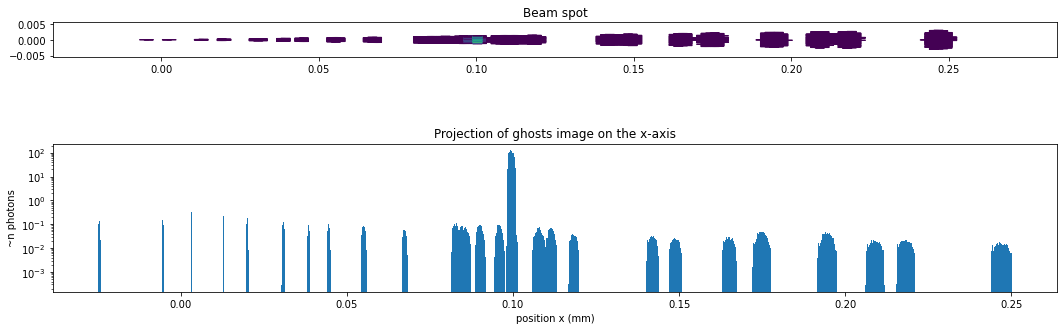

0

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


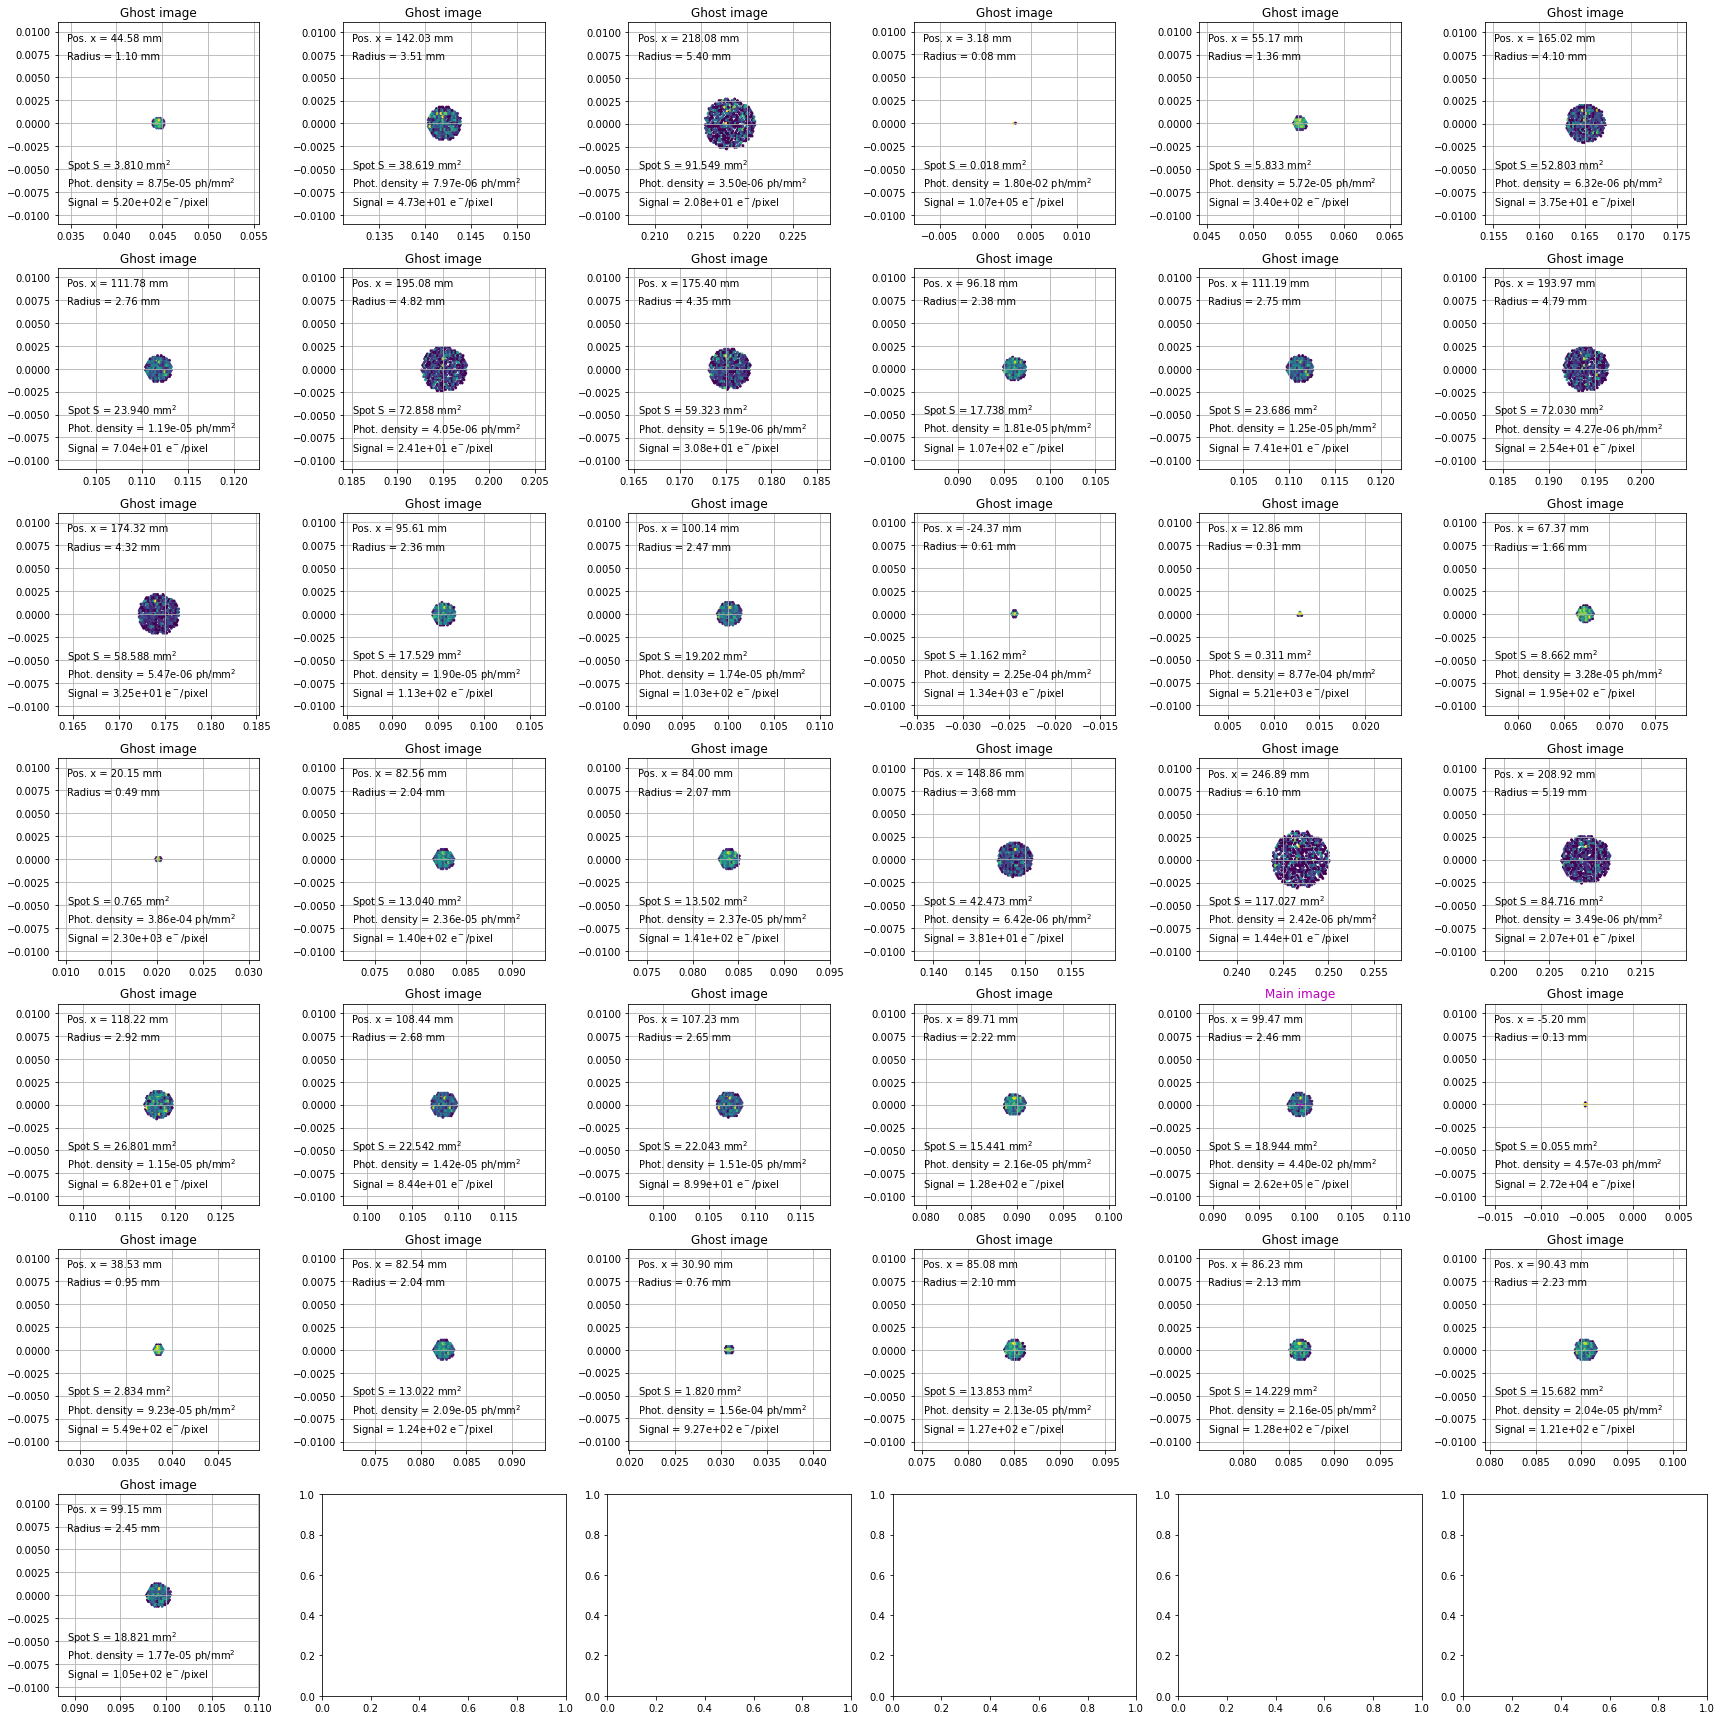

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1)
data_frame_1.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,pos_y,width_x,width_y,radius,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085082,2.166316e-05,0.002114,0.002086,0.002100,13.852698,126.743720
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086230,2.195532e-05,0.002142,0.002114,0.002128,14.229416,128.475878
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",-0.005196,-1.322912e-06,0.000137,0.000127,0.000132,0.054995,27161.006646
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.038532,9.810958e-06,0.000955,0.000945,0.000950,2.834080,548.788675
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082541,2.101611e-05,0.002048,0.002024,0.002036,13.021574,124.365997
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.030902,7.868036e-06,0.000765,0.000758,0.000761,1.819744,926.621969
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090430,2.302475e-05,0.002252,0.002217,0.002234,15.682353,121.379487
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099148,2.524441e-05,0.002465,0.002431,0.002448,18.821446,105.305581
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.111185,2.830930e-05,0.002766,0.002726,0.002746,23.685572,74.127088
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.193966,4.938647e-05,0.004821,0.004755,0.004788,72.030216,25.380136


Rotation around Y as Euler:
 [0. 1. 0.]
Rotation around Y as  matrix:
 [[ 0.9998477   0.          0.01745241]
 [ 0.          1.          0.        ]
 [-0.01745241  0.          0.9998477 ]]
L1 before rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L1 after rotation:
 [[ 0.9998477   0.          0.01745241]
 [ 0.          1.          0.        ]
 [-0.01745241  0.          0.9998477 ]]
Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


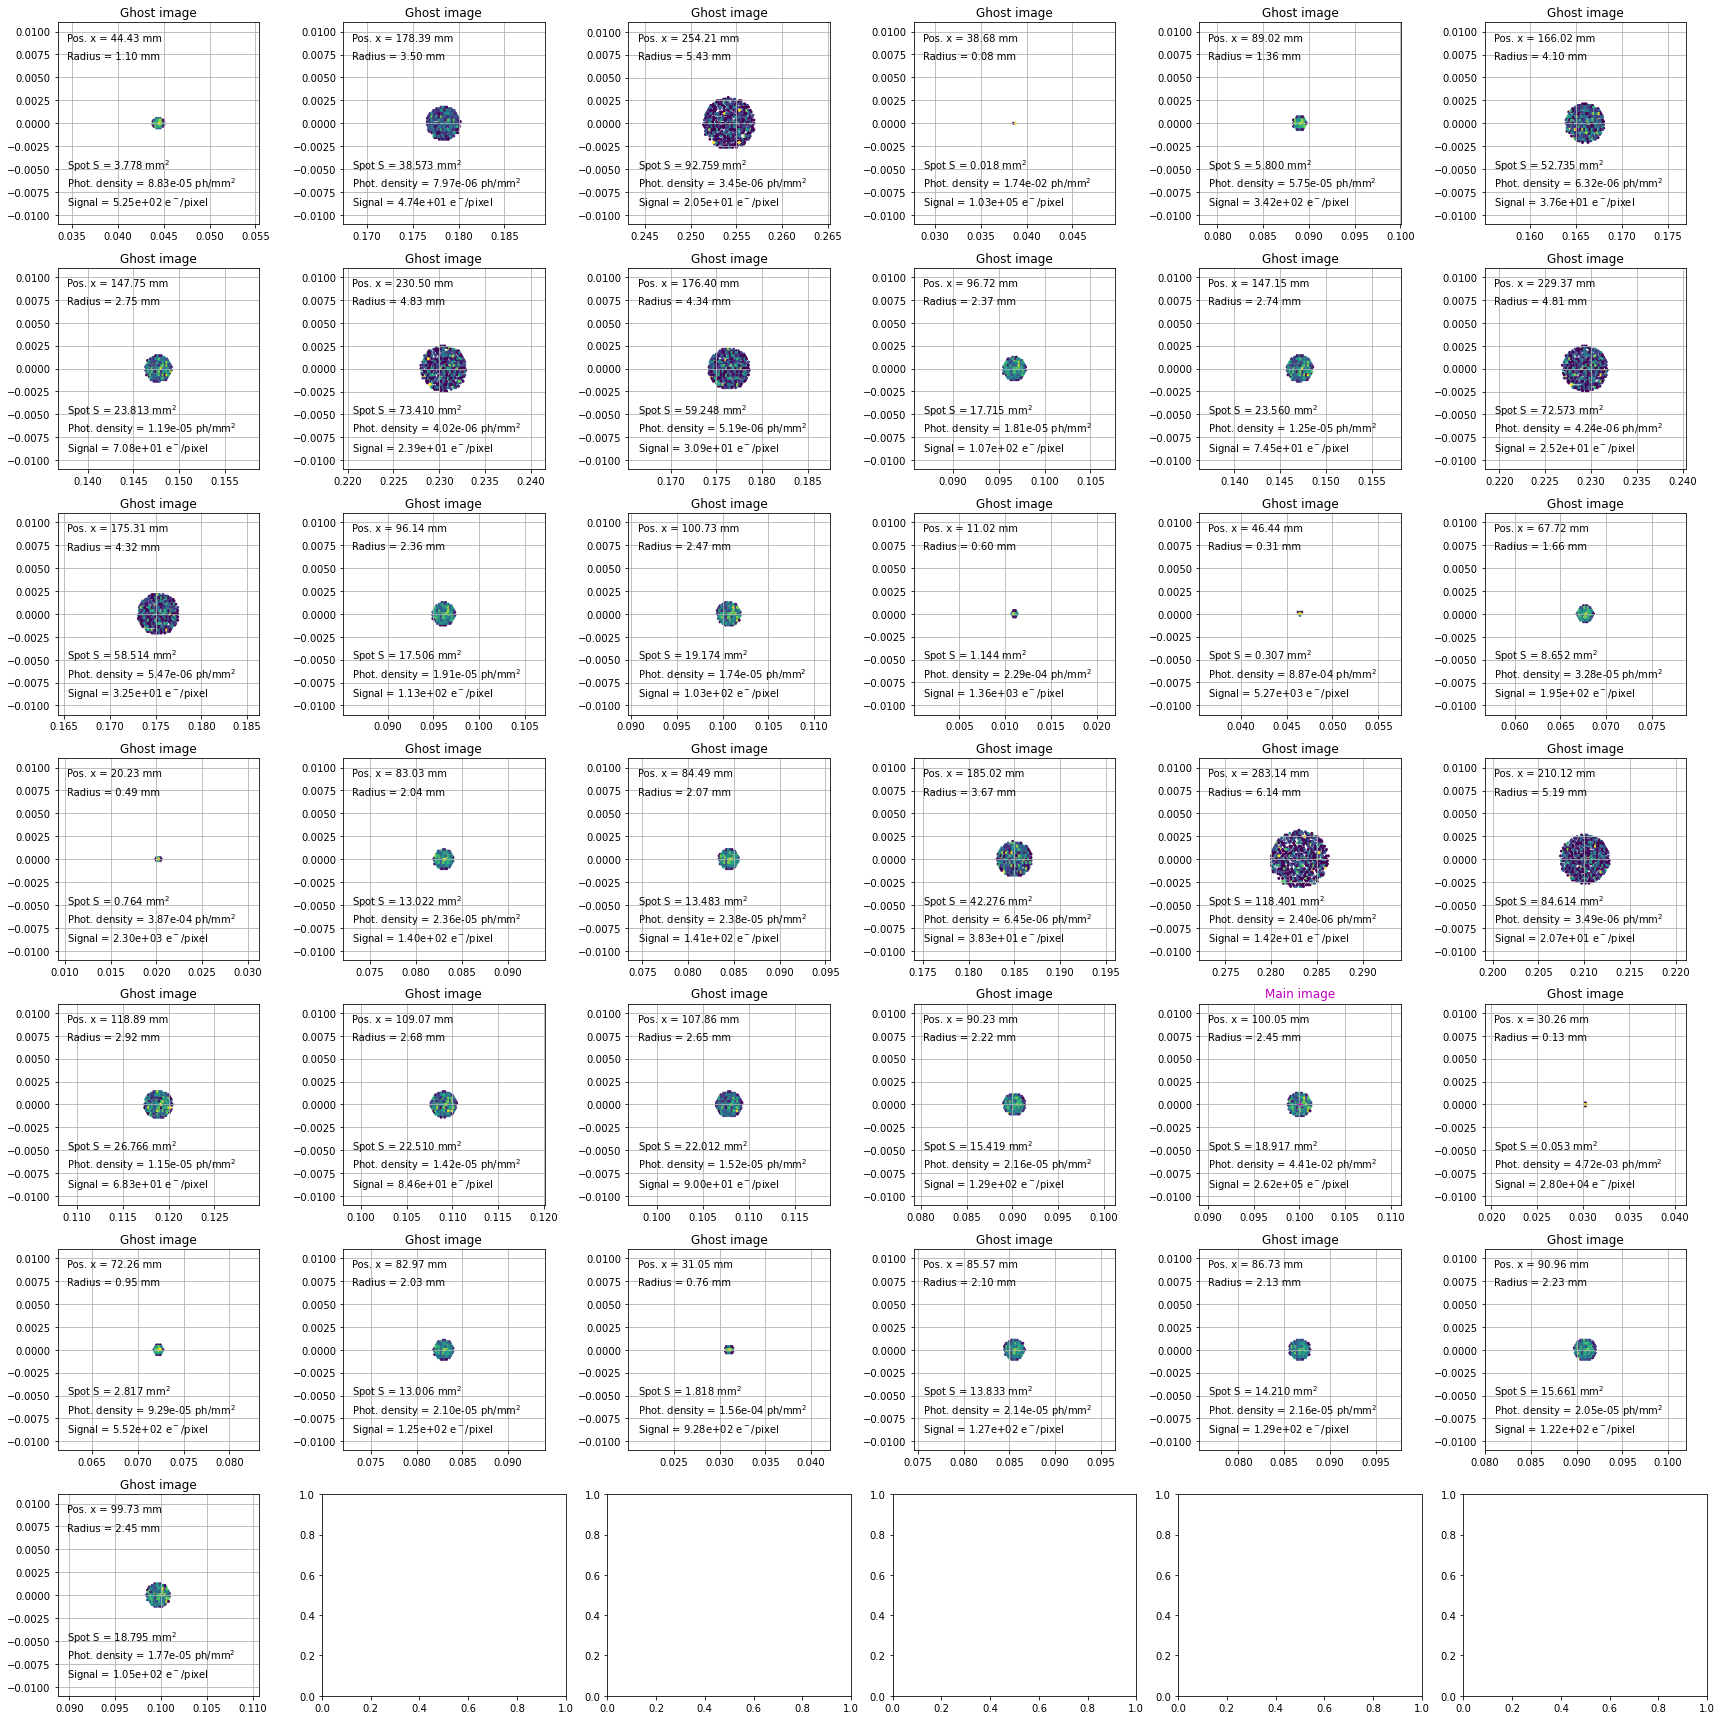

In [10]:
# Run another simulation with rotated L1
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L1', axis='y', angle=1, verbose=True)
tweak_optics.make_optics_reflective(rotated_telescope)

traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(rotated_telescope,
                                                                       beam_config=BEAM_CONFIG_1)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1)
data_frame_2.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,pos_y,width_x,width_y,radius,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085571,6.187401e-06,0.002092,0.002105,0.002098,13.833471,126.919881
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086727,6.270845e-06,0.002120,0.002133,0.002127,14.209608,128.654972
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",0.030258,-3.763292e-07,0.000133,0.000128,0.000130,0.053296,28027.046078
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.072258,2.797331e-06,0.000942,0.000952,0.000947,2.816963,552.123439
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082974,6.002781e-06,0.002027,0.002042,0.002035,13.005672,124.518060
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.031047,2.247336e-06,0.000757,0.000765,0.000761,1.817781,927.623032
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090957,6.576465e-06,0.002228,0.002237,0.002233,15.660614,121.547978
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099728,7.210256e-06,0.002439,0.002453,0.002446,18.794723,105.455309
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.147150,8.080491e-06,0.002728,0.002749,0.002739,23.560288,74.521267
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.229374,1.414701e-05,0.004800,0.004813,0.004806,72.573180,25.190252


In [12]:
match = match_ghosts(data_frame_1, data_frame_2)
match

,ghost_1,ghost_2,distance
0,0,0,0.000158
1,1,10,0.005121
2,2,23,0.007965
3,3,15,0.007845
4,4,16,0.008728
5,5,5,0.000997
6,6,25,0.002709
7,7,21,0.010058
8,8,12,0.000091
9,9,13,0.000036


In [13]:
compute_reduced_distance(match)

5.409493888260595e-05

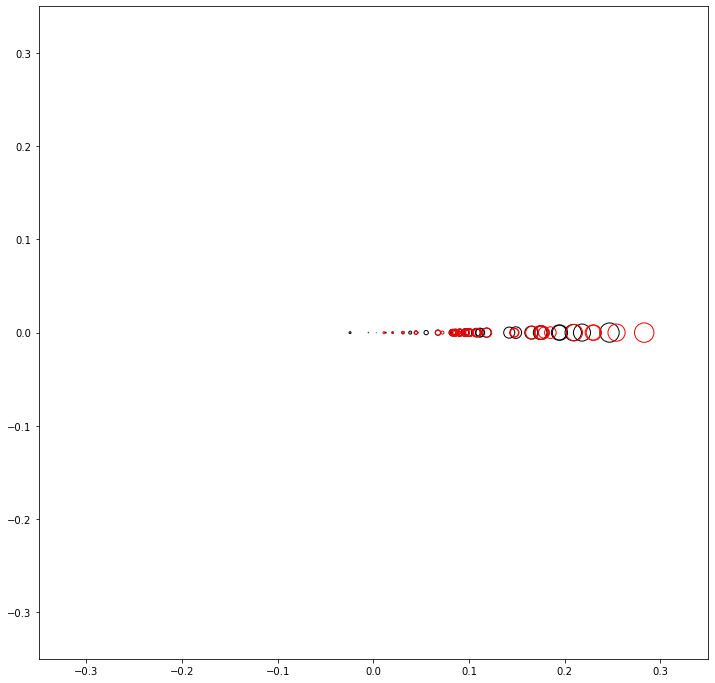

In [14]:
fig, ax = plotter.plot_spots([data_frame_1, data_frame_2])

In [17]:
# See what happens with a random telescope
data_frame_r, ghost_separations_r = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance = 0.00005


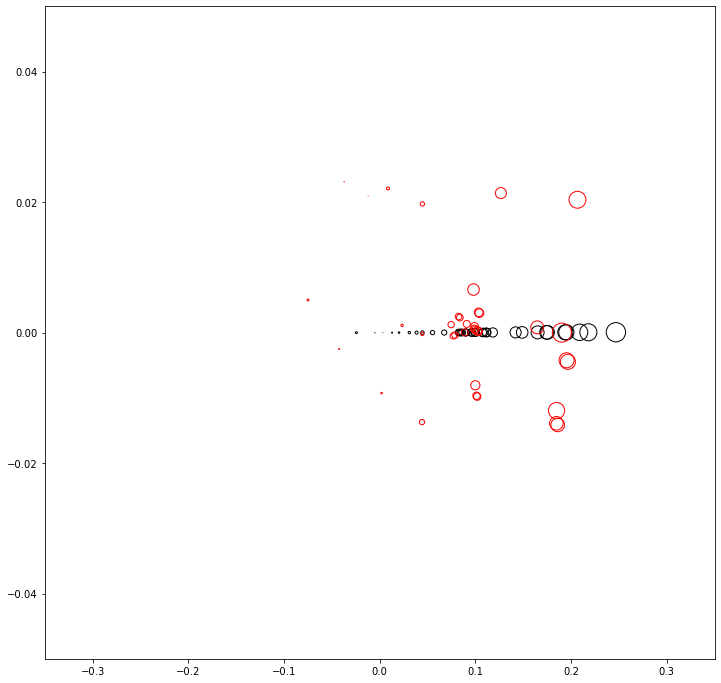

In [24]:
match_r = match_ghosts(data_frame_1, data_frame_r)
dist_r = compute_reduced_distance(match)
print(f'distance = {dist_r:.5f}')
fig, ax = plotter.plot_spots([data_frame_1, data_frame_r], range_y=(-0.05, 0.05))


In [38]:
SHORT_BEAM_CONFIG = copy.copy(BEAM_CONFIG_1)
SHORT_BEAM_CONFIG['n_photons']=10

distances = list()
for i in range(1000):
    df_i, gs_i = simulator.full_random_telescope_sim(telescope,\
                         max_angle=1, max_shift=0.00001, beam_config=SHORT_BEAM_CONFIG)
    match_i = match_ghosts(data_frame_1, df_i)
    dist_i = compute_reduced_distance(match_i)
    distances.append(dist_i)
    print(f'distance {i} = {dist_i:.6f}')


distance 0 = 0.001484
distance 1 = 0.001789
distance 2 = 0.002207
distance 3 = 0.002695
distance 4 = 0.001843
distance 5 = 0.001357
distance 6 = 0.001645
distance 7 = 0.002490
distance 8 = 0.001377
distance 9 = 0.002088
distance 10 = 0.001593
distance 11 = 0.002439
distance 12 = 0.002202
distance 13 = 0.001551
distance 14 = 0.001988
distance 15 = 0.002317
distance 16 = 0.002741
distance 17 = 0.002107
distance 18 = 0.001584
distance 19 = 0.001314
distance 20 = 0.002123
distance 21 = 0.001683
distance 22 = 0.001673
distance 23 = 0.002348
distance 24 = 0.002158
distance 25 = 0.002006
distance 26 = 0.001999
distance 27 = 0.002765
distance 28 = 0.002248
distance 29 = 0.002599
distance 30 = 0.001859
distance 31 = 0.002788
distance 32 = 0.001582
distance 33 = 0.001859
distance 34 = 0.002131
distance 35 = 0.002264
distance 36 = 0.001491
distance 37 = 0.002418
distance 38 = 0.001914
distance 39 = 0.002801
distance 40 = 0.001778
distance 41 = 0.001130
distance 42 = 0.002035
distance 43 = 0.00226

distance 346 = 0.002282
distance 347 = 0.001661
distance 348 = 0.001731
distance 349 = 0.002666
distance 350 = 0.000900
distance 351 = 0.002583
distance 352 = 0.001847
distance 353 = 0.002267
distance 354 = 0.001991
distance 355 = 0.001728
distance 356 = 0.002067
distance 357 = 0.001811
distance 358 = 0.002408
distance 359 = 0.002324
distance 360 = 0.001753
distance 361 = 0.002599
distance 362 = 0.001900
distance 363 = 0.002342
distance 364 = 0.001598
distance 365 = 0.001726
distance 366 = 0.001779
distance 367 = 0.001725
distance 368 = 0.002130
distance 369 = 0.002244
distance 370 = 0.002034
distance 371 = 0.002336
distance 372 = 0.002031
distance 373 = 0.001222
distance 374 = 0.002144
distance 375 = 0.002254
distance 376 = 0.001567
distance 377 = 0.002563
distance 378 = 0.001523
distance 379 = 0.001843
distance 380 = 0.002078
distance 381 = 0.002104
distance 382 = 0.001424
distance 383 = 0.001786
distance 384 = 0.001640
distance 385 = 0.002008
distance 386 = 0.001854
distance 387 = 0

distance 688 = 0.001877
distance 689 = 0.001796
distance 690 = 0.001999
distance 691 = 0.001509
distance 692 = 0.001274
distance 693 = 0.001858
distance 694 = 0.002851
distance 695 = 0.002040
distance 696 = 0.002421
distance 697 = 0.001732
distance 698 = 0.002393
distance 699 = 0.000986
distance 700 = 0.001843
distance 701 = 0.001365
distance 702 = 0.001161
distance 703 = 0.001495
distance 704 = 0.001783
distance 705 = 0.001549
distance 706 = 0.002546
distance 707 = 0.001390
distance 708 = 0.003049
distance 709 = 0.001824
distance 710 = 0.001933
distance 711 = 0.001522
distance 712 = 0.002183
distance 713 = 0.001472
distance 714 = 0.001946
distance 715 = 0.001726
distance 716 = 0.002073
distance 717 = 0.002622
distance 718 = 0.002188
distance 719 = 0.002324
distance 720 = 0.002124
distance 721 = 0.002183
distance 722 = 0.001772
distance 723 = 0.001722
distance 724 = 0.002488
distance 725 = 0.002313
distance 726 = 0.001969
distance 727 = 0.002166
distance 728 = 0.002461
distance 729 = 0

(array([  8.,  36., 103., 189., 226., 189., 137.,  85.,  18.,   9.]),
 array([0.00084135, 0.00107461, 0.00130787, 0.00154113, 0.00177439,
        0.00200765, 0.00224091, 0.00247417, 0.00270743, 0.00294069,
        0.00317396]),
 <BarContainer object of 10 artists>)

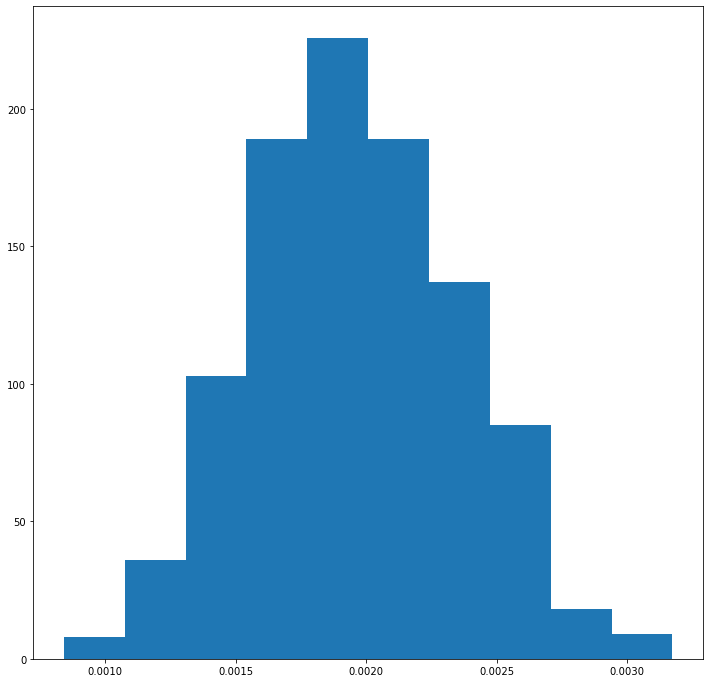

In [39]:
plt.hist(distances)